<h2>Figure 5, bounded plot only</h2>

In [1]:
import scipy.io
import tensorflow as tf   # tested with tf 1.15.3
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import genfromtxt
from aux_functions2 import xavier_init
from aux_functions2 import plot #MINE

import csv
import sys

In [2]:
steps = 60000 # number of training steps
iteration = 5 # number of iterations (iid runs based on available files, data shuffled and subsampled at 80%)
d = 16 # dimensions aka proteins
mb_size = 4000 # batch size
alpha_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
w = 0.2 # sick cell contamination
print(steps)
print(iteration)
print(d)
print(mb_size)


60000
5
16
4000


In [3]:
# hyperparameters
if d==6:                       
    layers = [d, 16, 16, 1] 
elif d==15:                       
    layers = [d, 16, 16, 1] 
elif d==2:
    layers = [d, 16, 16, 8, 1]
elif d==10:
    layers = [d, 16, 16, 8, 1]#[d, 32, 32, 16, 1]
elif d == 16:
    layers = [d, 16, 16, 8, 1]
elif d==50:
    layers = [d, 64, 64, 32, 1]
elif d==1:                     
    layers = [d, 8, 8, 4, 1]
else:
    raise Exception("Check dimension and layers...")

lam = 1.0 # lambda=beta+gamma

# initialize
X = tf.placeholder(tf.float32, shape=[None, d])
Y = tf.placeholder(tf.float32, shape=[None, d])

def initialize_NN(layers):
    NN_W = []
    NN_b = []
    num_layers = len(layers)
    for l in range(0,num_layers-1):
        W = tf.Variable(xavier_init(size=[layers[l], layers[l+1]]), name="W")
        b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
        NN_W.append(W)
        NN_b.append(b)
    return NN_W, NN_b

D_W, D_b = initialize_NN(layers)

theta_D = [D_W, D_b] 


In [4]:
def discriminator(x):
    num_layers = len(D_W) + 1
    
    h = x  
    for l in range(0,num_layers-2):
        W = D_W[l]
        b = D_b[l]
        h = tf.tanh(tf.add(tf.matmul(h, W), b))
    
    W = D_W[-1]
    b = D_b[-1]
    out = 5.0 * tf.nn.tanh(tf.add(tf.matmul(h, W), b) / 5.0) # bound M=5

    return out

D_real = discriminator(X)
D_fake = discriminator(Y)


In [5]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

SF = 1000
D_loss_vals =  np.zeros(shape=(len(alpha_range), iteration)) 
D_loss_vals_w_005 =  np.zeros(shape=(len(alpha_range), iteration)) 


In [6]:
# estimate Renyi divergence

# Loop over #samples, then over iid iterations and then over training steps
for j, alpha_i in enumerate(alpha_range): 
    
    print('j=', j)

    #alpha = alpha_range
    #No_alpha = len(alpha_range)

    
    beta = lam*(1-alpha_i)  
    gamma = lam*alpha_i  
    
    
    # variational representation:
    if beta == 0:
        D_loss_real = -tf.reduce_mean(D_real)
    else:
        max_val = tf.reduce_max((-beta) * D_real)
        D_loss_real = (1.0 / beta) * (tf.log(tf.reduce_mean(tf.exp((-beta) * D_real - max_val))) + max_val)

    if gamma == 0:
        D_loss_fake = tf.reduce_mean(D_fake)

    else:
        max_val = tf.reduce_max((gamma) * D_fake)
        D_loss_fake = (1.0 / gamma) * (tf.log(tf.reduce_mean(tf.exp(gamma * D_fake - max_val))) + max_val)

    D_loss = D_loss_real + D_loss_fake
    total_loss = D_loss

    D_solver = tf.train.AdamOptimizer(learning_rate=0.01).minimize(total_loss, var_list=theta_D)

    for iter in range(iteration):
        print('Iteration: {}'.format(iter))
        sess.run(tf.global_variables_initializer())
        
        # load data
        file_id = iter + 1 
        fname = 'data/all_Healthy_vs_CBF_20perc_markers_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16/H3_H4_H5_H6_H7_vs_CBF_perc4_markers_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_'
        data = scipy.io.loadmat(fname + 'iter_'+str(file_id)+'.mat')
        # SWAPPED X<->Y (Y is CBF)
        x = np.array(data['Y'])
        y = np.array(data['X'])

        # initialize for plotting
        i = 0
        Pl_freq = 10
        D_loss_plot = np.zeros(shape=((np.rint(steps / Pl_freq)).astype(int), 1))  # because we writeout every Pl_freq

        for it in range(steps):
            X_mb = x[np.random.randint(x.shape[0], size=mb_size), :]
            Y_mb = y[np.random.randint(y.shape[0], size=mb_size), :]

            _, D_loss_curr, D_tot_loss = sess.run([D_solver, D_loss, total_loss], feed_dict={X: X_mb, Y: Y_mb})

            if it % Pl_freq == 0:
                D_loss_plot[i] = D_loss_curr
                i += 1

            if it % SF == 0:
                print('Iter: {}'.format(it))
                print('Renyi divergence: {}'.format(-lam*D_loss_curr))
                print()


        D_loss_curr = sess.run(D_loss, feed_dict={X: x, Y: y})
        D_loss_vals[j,iter] = -lam * D_loss_curr

        
        
# w=0.05
    for iter in range(iteration):
        print('Iteration: {}'.format(iter))
        sess.run(tf.global_variables_initializer())
        
        # load data
        file_id = iter + 1 
        fname = 'data/all_Healthy_vs_CBF_5perc_markers_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16/input_files/H3_H4_H5_H6_H7_vs_CBF_perc2_markers_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_'
        data = scipy.io.loadmat(fname + 'iter_'+str(file_id)+'.mat')
        # SWAPPED X<->Y (Y is CBF)
        x = np.array(data['Y'])
        y = np.array(data['X'])

        # initialize for plotting
        i = 0
        Pl_freq = 10
        D_loss_plot = np.zeros(shape=((np.rint(steps / Pl_freq)).astype(int), 1))  # because we writeout every Pl_freq

        for it in range(steps):
            X_mb = x[np.random.randint(x.shape[0], size=mb_size), :]
            Y_mb = y[np.random.randint(y.shape[0], size=mb_size), :]

            _, D_loss_curr, D_tot_loss = sess.run([D_solver, D_loss, total_loss], feed_dict={X: X_mb, Y: Y_mb})

            if it % Pl_freq == 0:
                D_loss_plot[i] = D_loss_curr
                i += 1

            if it % SF == 0:
                print('Iter: {}'.format(it))
                print('Renyi divergence: {}'.format(-lam*D_loss_curr))
                print()


        D_loss_curr = sess.run(D_loss, feed_dict={X: x, Y: y})
        D_loss_vals_w_005[j,iter] = -lam * D_loss_curr
        
        


j= 0
Iteration: 0
Iter: 0
Renyi divergence: 8.336798055097461e-05

Iter: 1000
Renyi divergence: 0.22650933265686035

Iter: 2000
Renyi divergence: 0.241896390914917

Iter: 3000
Renyi divergence: 0.22150611877441406

Iter: 4000
Renyi divergence: 0.23701047897338867

Iter: 5000
Renyi divergence: 0.22452831268310547

Iter: 6000
Renyi divergence: 0.2438526153564453

Iter: 7000
Renyi divergence: 0.23793840408325195

Iter: 8000
Renyi divergence: 0.23978710174560547

Iter: 9000
Renyi divergence: 0.23703718185424805

Iter: 10000
Renyi divergence: 0.2379918098449707

Iter: 11000
Renyi divergence: 0.23345422744750977

Iter: 12000
Renyi divergence: 0.23984718322753906

Iter: 13000
Renyi divergence: 0.24538135528564453

Iter: 14000
Renyi divergence: 0.24380922317504883

Iter: 15000
Renyi divergence: 0.2524750232696533

Iter: 16000
Renyi divergence: 0.2342853546142578

Iter: 17000
Renyi divergence: 0.25315237045288086

Iter: 18000
Renyi divergence: 0.24018096923828125

Iter: 19000
Renyi divergence: 

Iter: 42000
Renyi divergence: 0.25070953369140625

Iter: 43000
Renyi divergence: 0.2441091537475586

Iter: 44000
Renyi divergence: 0.256040096282959

Iter: 45000
Renyi divergence: 0.25362682342529297

Iter: 46000
Renyi divergence: 0.24422979354858398

Iter: 47000
Renyi divergence: 0.23607254028320312

Iter: 48000
Renyi divergence: 0.2534513473510742

Iter: 49000
Renyi divergence: 0.23369550704956055

Iter: 50000
Renyi divergence: 0.25455188751220703

Iter: 51000
Renyi divergence: 0.24111223220825195

Iter: 52000
Renyi divergence: 0.2550630569458008

Iter: 53000
Renyi divergence: 0.22296142578125

Iter: 54000
Renyi divergence: 0.21534442901611328

Iter: 55000
Renyi divergence: 0.25503015518188477

Iter: 56000
Renyi divergence: 0.25391626358032227

Iter: 57000
Renyi divergence: 0.24318408966064453

Iter: 58000
Renyi divergence: 0.24503421783447266

Iter: 59000
Renyi divergence: 0.2595095634460449

Iteration: 3
Iter: 0
Renyi divergence: 6.579456385225058e-05

Iter: 1000
Renyi divergence: 

Iter: 24000
Renyi divergence: 0.08207058906555176

Iter: 25000
Renyi divergence: 0.07334566116333008

Iter: 26000
Renyi divergence: 0.0729297399520874

Iter: 27000
Renyi divergence: 0.07823848724365234

Iter: 28000
Renyi divergence: 0.07307779788970947

Iter: 29000
Renyi divergence: 0.07077538967132568

Iter: 30000
Renyi divergence: 0.05836212635040283

Iter: 31000
Renyi divergence: 0.07327461242675781

Iter: 32000
Renyi divergence: 0.07340508699417114

Iter: 33000
Renyi divergence: 0.06456583738327026

Iter: 34000
Renyi divergence: 0.06534959375858307

Iter: 35000
Renyi divergence: 0.07426509261131287

Iter: 36000
Renyi divergence: 0.07689909636974335

Iter: 37000
Renyi divergence: 0.07074558734893799

Iter: 38000
Renyi divergence: 0.061581358313560486

Iter: 39000
Renyi divergence: 0.07513251900672913

Iter: 40000
Renyi divergence: 0.08467952907085419

Iter: 41000
Renyi divergence: 0.060619741678237915

Iter: 42000
Renyi divergence: 0.06553465127944946

Iter: 43000
Renyi divergence: 

Iter: 5000
Renyi divergence: 0.04908180236816406

Iter: 6000
Renyi divergence: 0.05509662628173828

Iter: 7000
Renyi divergence: 0.04962348937988281

Iter: 8000
Renyi divergence: 0.06372356414794922

Iter: 9000
Renyi divergence: 0.06354379653930664

Iter: 10000
Renyi divergence: 0.05619192123413086

Iter: 11000
Renyi divergence: 0.0664224624633789

Iter: 12000
Renyi divergence: 0.05762338638305664

Iter: 13000
Renyi divergence: 0.05583333969116211

Iter: 14000
Renyi divergence: 0.05381011962890625

Iter: 15000
Renyi divergence: 0.07124888896942139

Iter: 16000
Renyi divergence: 0.07868504524230957

Iter: 17000
Renyi divergence: 0.064177006483078

Iter: 18000
Renyi divergence: 0.06801944971084595

Iter: 19000
Renyi divergence: 0.06352250277996063

Iter: 20000
Renyi divergence: 0.06312580406665802

Iter: 21000
Renyi divergence: 0.061520710587501526

Iter: 22000
Renyi divergence: 0.06828039884567261

Iter: 23000
Renyi divergence: 0.07644183933734894

Iter: 24000
Renyi divergence: 0.052371

Iter: 46000
Renyi divergence: 0.28754615783691406

Iter: 47000
Renyi divergence: 0.2686285972595215

Iter: 48000
Renyi divergence: 0.27663326263427734

Iter: 49000
Renyi divergence: 0.2787799835205078

Iter: 50000
Renyi divergence: 0.2677001953125

Iter: 51000
Renyi divergence: 0.25992774963378906

Iter: 52000
Renyi divergence: 0.28252553939819336

Iter: 53000
Renyi divergence: 0.26774168014526367

Iter: 54000
Renyi divergence: 0.2894582748413086

Iter: 55000
Renyi divergence: 0.26946067810058594

Iter: 56000
Renyi divergence: 0.28345298767089844

Iter: 57000
Renyi divergence: 0.26403188705444336

Iter: 58000
Renyi divergence: 0.2705373764038086

Iter: 59000
Renyi divergence: 0.2664608955383301

Iteration: 1
Iter: 0
Renyi divergence: -7.689492485951632e-05

Iter: 1000
Renyi divergence: 0.2453463077545166

Iter: 2000
Renyi divergence: 0.26120805740356445

Iter: 3000
Renyi divergence: 0.24195337295532227

Iter: 4000
Renyi divergence: 0.2617216110229492

Iter: 5000
Renyi divergence: 0.257

Iter: 29000
Renyi divergence: 0.28645896911621094

Iter: 30000
Renyi divergence: 0.2796211242675781

Iter: 31000
Renyi divergence: 0.26406383514404297

Iter: 32000
Renyi divergence: 0.2686448097229004

Iter: 33000
Renyi divergence: 0.2642397880554199

Iter: 34000
Renyi divergence: 0.2696247100830078

Iter: 35000
Renyi divergence: 0.2595062255859375

Iter: 36000
Renyi divergence: 0.28740453720092773

Iter: 37000
Renyi divergence: 0.2691779136657715

Iter: 38000
Renyi divergence: 0.28406333923339844

Iter: 39000
Renyi divergence: 0.2916598320007324

Iter: 40000
Renyi divergence: 0.2549858093261719

Iter: 41000
Renyi divergence: 0.2635173797607422

Iter: 42000
Renyi divergence: 0.28208208084106445

Iter: 43000
Renyi divergence: 0.26686620712280273

Iter: 44000
Renyi divergence: 0.27944517135620117

Iter: 45000
Renyi divergence: 0.2850799560546875

Iter: 46000
Renyi divergence: 0.29005861282348633

Iter: 47000
Renyi divergence: 0.2708110809326172

Iter: 48000
Renyi divergence: 0.2755560874

Iter: 11000
Renyi divergence: 0.07048821449279785

Iter: 12000
Renyi divergence: 0.06781911849975586

Iter: 13000
Renyi divergence: 0.06830120086669922

Iter: 14000
Renyi divergence: 0.08819866180419922

Iter: 15000
Renyi divergence: 0.08327841758728027

Iter: 16000
Renyi divergence: 0.0773477554321289

Iter: 17000
Renyi divergence: 0.07451367378234863

Iter: 18000
Renyi divergence: 0.0847930908203125

Iter: 19000
Renyi divergence: 0.07756543159484863

Iter: 20000
Renyi divergence: 0.07824134826660156

Iter: 21000
Renyi divergence: 0.07564640045166016

Iter: 22000
Renyi divergence: 0.08095860481262207

Iter: 23000
Renyi divergence: 0.08005762100219727

Iter: 24000
Renyi divergence: 0.07507181167602539

Iter: 25000
Renyi divergence: 0.08030986785888672

Iter: 26000
Renyi divergence: 0.07014632225036621

Iter: 27000
Renyi divergence: 0.078072190284729

Iter: 28000
Renyi divergence: 0.0894695520401001

Iter: 29000
Renyi divergence: 0.07953214645385742

Iter: 30000
Renyi divergence: 0.0827

Iter: 52000
Renyi divergence: 0.06977510452270508

Iter: 53000
Renyi divergence: 0.07323026657104492

Iter: 54000
Renyi divergence: 0.07750988006591797

Iter: 55000
Renyi divergence: 0.07206201553344727

Iter: 56000
Renyi divergence: 0.07509565353393555

Iter: 57000
Renyi divergence: 0.06764745712280273

Iter: 58000
Renyi divergence: 0.07146406173706055

Iter: 59000
Renyi divergence: 0.08504724502563477

Iteration: 4
Iter: 0
Renyi divergence: -1.2742821127176285e-05

Iter: 1000
Renyi divergence: 0.052271366119384766

Iter: 2000
Renyi divergence: 0.05336427688598633

Iter: 3000
Renyi divergence: 0.0539088249206543

Iter: 4000
Renyi divergence: 0.055407047271728516

Iter: 5000
Renyi divergence: 0.06124114990234375

Iter: 6000
Renyi divergence: 0.061292171478271484

Iter: 7000
Renyi divergence: 0.06173276901245117

Iter: 8000
Renyi divergence: 0.056326866149902344

Iter: 9000
Renyi divergence: 0.0711069107055664

Iter: 10000
Renyi divergence: 0.06902885437011719

Iter: 11000
Renyi diverge

Iter: 34000
Renyi divergence: 0.3235592842102051

Iter: 35000
Renyi divergence: 0.3034052848815918

Iter: 36000
Renyi divergence: 0.2855863571166992

Iter: 37000
Renyi divergence: 0.30379295349121094

Iter: 38000
Renyi divergence: 0.3027067184448242

Iter: 39000
Renyi divergence: 0.27664613723754883

Iter: 40000
Renyi divergence: 0.2971158027648926

Iter: 41000
Renyi divergence: 0.3103647232055664

Iter: 42000
Renyi divergence: 0.3028450012207031

Iter: 43000
Renyi divergence: 0.2662506103515625

Iter: 44000
Renyi divergence: 0.29102277755737305

Iter: 45000
Renyi divergence: 0.3024330139160156

Iter: 46000
Renyi divergence: 0.30113649368286133

Iter: 47000
Renyi divergence: 0.3061714172363281

Iter: 48000
Renyi divergence: 0.34369754791259766

Iter: 49000
Renyi divergence: 0.29236316680908203

Iter: 50000
Renyi divergence: 0.31633949279785156

Iter: 51000
Renyi divergence: 0.3172926902770996

Iter: 52000
Renyi divergence: 0.29611778259277344

Iter: 53000
Renyi divergence: 0.3178000450

Iter: 17000
Renyi divergence: 0.31073808670043945

Iter: 18000
Renyi divergence: 0.30881261825561523

Iter: 19000
Renyi divergence: 0.3037567138671875

Iter: 20000
Renyi divergence: 0.27869415283203125

Iter: 21000
Renyi divergence: 0.3154029846191406

Iter: 22000
Renyi divergence: 0.30589818954467773

Iter: 23000
Renyi divergence: 0.30280399322509766

Iter: 24000
Renyi divergence: 0.3271193504333496

Iter: 25000
Renyi divergence: 0.2990427017211914

Iter: 26000
Renyi divergence: 0.30524635314941406

Iter: 27000
Renyi divergence: 0.3207516670227051

Iter: 28000
Renyi divergence: 0.2975006103515625

Iter: 29000
Renyi divergence: 0.3148460388183594

Iter: 30000
Renyi divergence: 0.3072929382324219

Iter: 31000
Renyi divergence: 0.2977156639099121

Iter: 32000
Renyi divergence: 0.3155369758605957

Iter: 33000
Renyi divergence: 0.3333897590637207

Iter: 34000
Renyi divergence: 0.30533838272094727

Iter: 35000
Renyi divergence: 0.3034210205078125

Iter: 36000
Renyi divergence: 0.31263875961

Iter: 59000
Renyi divergence: 0.07573270797729492

Iteration: 2
Iter: 0
Renyi divergence: -4.707486368715763e-05

Iter: 1000
Renyi divergence: 0.06804847717285156

Iter: 2000
Renyi divergence: 0.053351402282714844

Iter: 3000
Renyi divergence: 0.05593299865722656

Iter: 4000
Renyi divergence: 0.07515907287597656

Iter: 5000
Renyi divergence: 0.06575536727905273

Iter: 6000
Renyi divergence: 0.06972217559814453

Iter: 7000
Renyi divergence: 0.0747075080871582

Iter: 8000
Renyi divergence: 0.07361268997192383

Iter: 9000
Renyi divergence: 0.06872224807739258

Iter: 10000
Renyi divergence: 0.07589101791381836

Iter: 11000
Renyi divergence: 0.07550811767578125

Iter: 12000
Renyi divergence: 0.08294868469238281

Iter: 13000
Renyi divergence: 0.07532691955566406

Iter: 14000
Renyi divergence: 0.07338619232177734

Iter: 15000
Renyi divergence: 0.07717418670654297

Iter: 16000
Renyi divergence: 0.08366823196411133

Iter: 17000
Renyi divergence: 0.07860612869262695

Iter: 18000
Renyi divergence

Iter: 41000
Renyi divergence: 0.0811605453491211

Iter: 42000
Renyi divergence: 0.07926416397094727

Iter: 43000
Renyi divergence: 0.07354307174682617

Iter: 44000
Renyi divergence: 0.0941009521484375

Iter: 45000
Renyi divergence: 0.078155517578125

Iter: 46000
Renyi divergence: 0.07719612121582031

Iter: 47000
Renyi divergence: 0.08487749099731445

Iter: 48000
Renyi divergence: 0.06933069229125977

Iter: 49000
Renyi divergence: 0.07077836990356445

Iter: 50000
Renyi divergence: 0.08579301834106445

Iter: 51000
Renyi divergence: 0.0832972526550293

Iter: 52000
Renyi divergence: 0.07959127426147461

Iter: 53000
Renyi divergence: 0.08515357971191406

Iter: 54000
Renyi divergence: 0.0756988525390625

Iter: 55000
Renyi divergence: 0.08519887924194336

Iter: 56000
Renyi divergence: 0.08293008804321289

Iter: 57000
Renyi divergence: 0.08267641067504883

Iter: 58000
Renyi divergence: 0.08264636993408203

Iter: 59000
Renyi divergence: 0.08410501480102539

j= 3
Iteration: 0
Iter: 0
Renyi diver

Iter: 24000
Renyi divergence: 0.35602569580078125

Iter: 25000
Renyi divergence: 0.3561100959777832

Iter: 26000
Renyi divergence: 0.3563871383666992

Iter: 27000
Renyi divergence: 0.3550252914428711

Iter: 28000
Renyi divergence: 0.36392784118652344

Iter: 29000
Renyi divergence: 0.3600621223449707

Iter: 30000
Renyi divergence: 0.3672323226928711

Iter: 31000
Renyi divergence: 0.364931583404541

Iter: 32000
Renyi divergence: 0.3641982078552246

Iter: 33000
Renyi divergence: 0.34417247772216797

Iter: 34000
Renyi divergence: 0.3695559501647949

Iter: 35000
Renyi divergence: 0.3493204116821289

Iter: 36000
Renyi divergence: 0.3340177536010742

Iter: 37000
Renyi divergence: 0.3455390930175781

Iter: 38000
Renyi divergence: 0.3461894989013672

Iter: 39000
Renyi divergence: 0.3629488945007324

Iter: 40000
Renyi divergence: 0.35388994216918945

Iter: 41000
Renyi divergence: 0.3610692024230957

Iter: 42000
Renyi divergence: 0.355562686920166

Iter: 43000
Renyi divergence: 0.3681039810180664

Iter: 7000
Renyi divergence: 0.08038139343261719

Iter: 8000
Renyi divergence: 0.07696247100830078

Iter: 9000
Renyi divergence: 0.07761192321777344

Iter: 10000
Renyi divergence: 0.08627080917358398

Iter: 11000
Renyi divergence: 0.08527803421020508

Iter: 12000
Renyi divergence: 0.07734394073486328

Iter: 13000
Renyi divergence: 0.09093475341796875

Iter: 14000
Renyi divergence: 0.09136486053466797

Iter: 15000
Renyi divergence: 0.08426427841186523

Iter: 16000
Renyi divergence: 0.08121585845947266

Iter: 17000
Renyi divergence: 0.08835792541503906

Iter: 18000
Renyi divergence: 0.07026433944702148

Iter: 19000
Renyi divergence: 0.08210897445678711

Iter: 20000
Renyi divergence: 0.08861351013183594

Iter: 21000
Renyi divergence: 0.09349250793457031

Iter: 22000
Renyi divergence: 0.09059906005859375

Iter: 23000
Renyi divergence: 0.07587528228759766

Iter: 24000
Renyi divergence: 0.09312963485717773

Iter: 25000
Renyi divergence: 0.08767127990722656

Iter: 26000
Renyi divergence: 0.05

Iter: 49000
Renyi divergence: 0.07584476470947266

Iter: 50000
Renyi divergence: 0.08281755447387695

Iter: 51000
Renyi divergence: 0.09102392196655273

Iter: 52000
Renyi divergence: 0.09659242630004883

Iter: 53000
Renyi divergence: 0.09729814529418945

Iter: 54000
Renyi divergence: 0.08524227142333984

Iter: 55000
Renyi divergence: 0.08808755874633789

Iter: 56000
Renyi divergence: 0.08511543273925781

Iter: 57000
Renyi divergence: 0.08592033386230469

Iter: 58000
Renyi divergence: 0.08436107635498047

Iter: 59000
Renyi divergence: 0.09606790542602539

Iteration: 3
Iter: 0
Renyi divergence: -2.1393061615526676e-06

Iter: 1000
Renyi divergence: 0.08272123336791992

Iter: 2000
Renyi divergence: 0.08078908920288086

Iter: 3000
Renyi divergence: 0.0754384994506836

Iter: 4000
Renyi divergence: 0.0680699348449707

Iter: 5000
Renyi divergence: 0.07397174835205078

Iter: 6000
Renyi divergence: 0.07815837860107422

Iter: 7000
Renyi divergence: 0.0832676887512207

Iter: 8000
Renyi divergence:

Iter: 31000
Renyi divergence: 0.40338754653930664

Iter: 32000
Renyi divergence: 0.429840087890625

Iter: 33000
Renyi divergence: 0.414431095123291

Iter: 34000
Renyi divergence: 0.4107027053833008

Iter: 35000
Renyi divergence: 0.3863396644592285

Iter: 36000
Renyi divergence: 0.4360051155090332

Iter: 37000
Renyi divergence: 0.40404462814331055

Iter: 38000
Renyi divergence: 0.40878915786743164

Iter: 39000
Renyi divergence: 0.4346318244934082

Iter: 40000
Renyi divergence: 0.3995223045349121

Iter: 41000
Renyi divergence: 0.4113330841064453

Iter: 42000
Renyi divergence: 0.3792543411254883

Iter: 43000
Renyi divergence: 0.4089970588684082

Iter: 44000
Renyi divergence: 0.3779873847961426

Iter: 45000
Renyi divergence: 0.41191816329956055

Iter: 46000
Renyi divergence: 0.41404056549072266

Iter: 47000
Renyi divergence: 0.42847156524658203

Iter: 48000
Renyi divergence: 0.39974212646484375

Iter: 49000
Renyi divergence: 0.4343600273132324

Iter: 50000
Renyi divergence: 0.3998365402221

Iter: 14000
Renyi divergence: 0.41750431060791016

Iter: 15000
Renyi divergence: 0.3995695114135742

Iter: 16000
Renyi divergence: 0.4159364700317383

Iter: 17000
Renyi divergence: 0.39209413528442383

Iter: 18000
Renyi divergence: 0.3931007385253906

Iter: 19000
Renyi divergence: 0.3911566734313965

Iter: 20000
Renyi divergence: 0.4056692123413086

Iter: 21000
Renyi divergence: 0.4301295280456543

Iter: 22000
Renyi divergence: 0.4001960754394531

Iter: 23000
Renyi divergence: 0.37915802001953125

Iter: 24000
Renyi divergence: 0.43714237213134766

Iter: 25000
Renyi divergence: 0.42907094955444336

Iter: 26000
Renyi divergence: 0.41906261444091797

Iter: 27000
Renyi divergence: 0.4230341911315918

Iter: 28000
Renyi divergence: 0.42109012603759766

Iter: 29000
Renyi divergence: 0.40134620666503906

Iter: 30000
Renyi divergence: 0.41081666946411133

Iter: 31000
Renyi divergence: 0.41933441162109375

Iter: 32000
Renyi divergence: 0.4160342216491699

Iter: 33000
Renyi divergence: 0.42761754

Iter: 56000
Renyi divergence: 0.09306144714355469

Iter: 57000
Renyi divergence: 0.09650945663452148

Iter: 58000
Renyi divergence: 0.09235382080078125

Iter: 59000
Renyi divergence: 0.11870479583740234

Iteration: 1
Iter: 0
Renyi divergence: -1.4440156519412994e-05

Iter: 1000
Renyi divergence: 0.0834207534790039

Iter: 2000
Renyi divergence: 0.07582998275756836

Iter: 3000
Renyi divergence: 0.08571195602416992

Iter: 4000
Renyi divergence: 0.0842289924621582

Iter: 5000
Renyi divergence: 0.08259105682373047

Iter: 6000
Renyi divergence: 0.07515478134155273

Iter: 7000
Renyi divergence: 0.08333826065063477

Iter: 8000
Renyi divergence: 0.09260225296020508

Iter: 9000
Renyi divergence: 0.08960580825805664

Iter: 10000
Renyi divergence: 0.09711694717407227

Iter: 11000
Renyi divergence: 0.08553361892700195

Iter: 12000
Renyi divergence: 0.0826559066772461

Iter: 13000
Renyi divergence: 0.08742904663085938

Iter: 14000
Renyi divergence: 0.08904218673706055

Iter: 15000
Renyi divergence: 

Iter: 37000
Renyi divergence: 0.08870315551757812

Iter: 38000
Renyi divergence: 0.12746620178222656

Iter: 39000
Renyi divergence: 0.10829401016235352

Iter: 40000
Renyi divergence: 0.09752035140991211

Iter: 41000
Renyi divergence: 0.08157539367675781

Iter: 42000
Renyi divergence: 0.0938100814819336

Iter: 43000
Renyi divergence: 0.09359931945800781

Iter: 44000
Renyi divergence: 0.08871269226074219

Iter: 45000
Renyi divergence: 0.11287879943847656

Iter: 46000
Renyi divergence: 0.10178470611572266

Iter: 47000
Renyi divergence: 0.08689260482788086

Iter: 48000
Renyi divergence: 0.10625600814819336

Iter: 49000
Renyi divergence: 0.0874934196472168

Iter: 50000
Renyi divergence: 0.10312414169311523

Iter: 51000
Renyi divergence: 0.09370183944702148

Iter: 52000
Renyi divergence: 0.07996797561645508

Iter: 53000
Renyi divergence: 0.11149787902832031

Iter: 54000
Renyi divergence: 0.08428382873535156

Iter: 55000
Renyi divergence: 0.10558223724365234

Iter: 56000
Renyi divergence: 0.1

Iter: 19000
Renyi divergence: 0.5447921752929688

Iter: 20000
Renyi divergence: 0.5111117362976074

Iter: 21000
Renyi divergence: 0.5243043899536133

Iter: 22000
Renyi divergence: 0.46611738204956055

Iter: 23000
Renyi divergence: 0.49285316467285156

Iter: 24000
Renyi divergence: 0.46520090103149414

Iter: 25000
Renyi divergence: 0.5149292945861816

Iter: 26000
Renyi divergence: 0.5036625862121582

Iter: 27000
Renyi divergence: 0.5014467239379883

Iter: 28000
Renyi divergence: 0.5243659019470215

Iter: 29000
Renyi divergence: 0.5028223991394043

Iter: 30000
Renyi divergence: 0.5171866416931152

Iter: 31000
Renyi divergence: 0.5189495086669922

Iter: 32000
Renyi divergence: 0.4883899688720703

Iter: 33000
Renyi divergence: 0.534034252166748

Iter: 34000
Renyi divergence: 0.5171270370483398

Iter: 35000
Renyi divergence: 0.48208189010620117

Iter: 36000
Renyi divergence: 0.5044145584106445

Iter: 37000
Renyi divergence: 0.43987035751342773

Iter: 38000
Renyi divergence: 0.49298238754272

Iter: 3000
Renyi divergence: 0.43785667419433594

Iter: 4000
Renyi divergence: 0.45449161529541016

Iter: 5000
Renyi divergence: 0.4457254409790039

Iter: 6000
Renyi divergence: 0.4587702751159668

Iter: 7000
Renyi divergence: 0.5004124641418457

Iter: 8000
Renyi divergence: 0.502312183380127

Iter: 9000
Renyi divergence: 0.48412513732910156

Iter: 10000
Renyi divergence: 0.4963393211364746

Iter: 11000
Renyi divergence: 0.4623074531555176

Iter: 12000
Renyi divergence: 0.4793572425842285

Iter: 13000
Renyi divergence: 0.5510082244873047

Iter: 14000
Renyi divergence: 0.5154132843017578

Iter: 15000
Renyi divergence: 0.4813408851623535

Iter: 16000
Renyi divergence: 0.5136170387268066

Iter: 17000
Renyi divergence: 0.47164154052734375

Iter: 18000
Renyi divergence: 0.45937252044677734

Iter: 19000
Renyi divergence: 0.521456241607666

Iter: 20000
Renyi divergence: 0.4868311882019043

Iter: 21000
Renyi divergence: 0.5170674324035645

Iter: 22000
Renyi divergence: 0.4614834785461426

Iter

Iter: 45000
Renyi divergence: 0.10332059860229492

Iter: 46000
Renyi divergence: 0.10242748260498047

Iter: 47000
Renyi divergence: 0.10216093063354492

Iter: 48000
Renyi divergence: 0.12514209747314453

Iter: 49000
Renyi divergence: 0.12126636505126953

Iter: 50000
Renyi divergence: 0.11900997161865234

Iter: 51000
Renyi divergence: 0.09875297546386719

Iter: 52000
Renyi divergence: 0.10947799682617188

Iter: 53000
Renyi divergence: 0.12059450149536133

Iter: 54000
Renyi divergence: 0.11986255645751953

Iter: 55000
Renyi divergence: 0.10759878158569336

Iter: 56000
Renyi divergence: 0.12200069427490234

Iter: 57000
Renyi divergence: 0.1049036979675293

Iter: 58000
Renyi divergence: 0.0943613052368164

Iter: 59000
Renyi divergence: 0.10590076446533203

Iteration: 2
Iter: 0
Renyi divergence: -3.825596650131047e-05

Iter: 1000
Renyi divergence: 0.09055519104003906

Iter: 2000
Renyi divergence: 0.0686483383178711

Iter: 3000
Renyi divergence: 0.0904841423034668

Iter: 4000
Renyi divergenc

Iter: 27000
Renyi divergence: 0.1050882339477539

Iter: 28000
Renyi divergence: 0.0970163345336914

Iter: 29000
Renyi divergence: 0.11537647247314453

Iter: 30000
Renyi divergence: 0.11250972747802734

Iter: 31000
Renyi divergence: 0.10807037353515625

Iter: 32000
Renyi divergence: 0.12436103820800781

Iter: 33000
Renyi divergence: 0.10598373413085938

Iter: 34000
Renyi divergence: 0.0989384651184082

Iter: 35000
Renyi divergence: 0.11601448059082031

Iter: 36000
Renyi divergence: 0.09314489364624023

Iter: 37000
Renyi divergence: 0.11331510543823242

Iter: 38000
Renyi divergence: 0.1110849380493164

Iter: 39000
Renyi divergence: 0.10803604125976562

Iter: 40000
Renyi divergence: 0.11577939987182617

Iter: 41000
Renyi divergence: 0.10223245620727539

Iter: 42000
Renyi divergence: 0.11183881759643555

Iter: 43000
Renyi divergence: 0.11832475662231445

Iter: 44000
Renyi divergence: 0.11405372619628906

Iter: 45000
Renyi divergence: 0.09978485107421875

Iter: 46000
Renyi divergence: 0.090

Iter: 11000
Renyi divergence: 0.615959644317627

Iter: 12000
Renyi divergence: 0.6402449607849121

Iter: 13000
Renyi divergence: 0.6006278991699219

Iter: 14000
Renyi divergence: 0.5351710319519043

Iter: 15000
Renyi divergence: 0.631932258605957

Iter: 16000
Renyi divergence: 0.5931673049926758

Iter: 17000
Renyi divergence: 0.6283111572265625

Iter: 18000
Renyi divergence: 0.6304879188537598

Iter: 19000
Renyi divergence: 0.5933823585510254

Iter: 20000
Renyi divergence: 0.6279540061950684

Iter: 21000
Renyi divergence: 0.6328701972961426

Iter: 22000
Renyi divergence: 0.6368832588195801

Iter: 23000
Renyi divergence: 0.6040434837341309

Iter: 24000
Renyi divergence: 0.6208124160766602

Iter: 25000
Renyi divergence: 0.6140966415405273

Iter: 26000
Renyi divergence: 0.5936346054077148

Iter: 27000
Renyi divergence: 0.6046266555786133

Iter: 28000
Renyi divergence: 0.5526242256164551

Iter: 29000
Renyi divergence: 0.5816540718078613

Iter: 30000
Renyi divergence: 0.6333780288696289

It

Iter: 56000
Renyi divergence: 0.6089634895324707

Iter: 57000
Renyi divergence: 0.6084833145141602

Iter: 58000
Renyi divergence: 0.6146755218505859

Iter: 59000
Renyi divergence: 0.5716705322265625

Iteration: 0
Iter: 0
Renyi divergence: -1.3585318811237812e-05

Iter: 1000
Renyi divergence: 0.11829328536987305

Iter: 2000
Renyi divergence: 0.11259269714355469

Iter: 3000
Renyi divergence: 0.1345357894897461

Iter: 4000
Renyi divergence: 0.12102890014648438

Iter: 5000
Renyi divergence: 0.1282491683959961

Iter: 6000
Renyi divergence: 0.11373519897460938

Iter: 7000
Renyi divergence: 0.11390113830566406

Iter: 8000
Renyi divergence: 0.13171672821044922

Iter: 9000
Renyi divergence: 0.12084770202636719

Iter: 10000
Renyi divergence: 0.12507009506225586

Iter: 11000
Renyi divergence: 0.0884237289428711

Iter: 12000
Renyi divergence: 0.14905500411987305

Iter: 13000
Renyi divergence: 0.10971403121948242

Iter: 14000
Renyi divergence: 0.1306772232055664

Iter: 15000
Renyi divergence: 0.124

Iter: 38000
Renyi divergence: 0.13240766525268555

Iter: 39000
Renyi divergence: 0.12404251098632812

Iter: 40000
Renyi divergence: 0.1186208724975586

Iter: 41000
Renyi divergence: 0.14050579071044922

Iter: 42000
Renyi divergence: 0.12024164199829102

Iter: 43000
Renyi divergence: 0.13478660583496094

Iter: 44000
Renyi divergence: 0.1539301872253418

Iter: 45000
Renyi divergence: 0.12789154052734375

Iter: 46000
Renyi divergence: 0.12092971801757812

Iter: 47000
Renyi divergence: 0.11575460433959961

Iter: 48000
Renyi divergence: 0.1204066276550293

Iter: 49000
Renyi divergence: 0.11359977722167969

Iter: 50000
Renyi divergence: 0.13591384887695312

Iter: 51000
Renyi divergence: 0.13459491729736328

Iter: 52000
Renyi divergence: 0.1255025863647461

Iter: 53000
Renyi divergence: 0.1024479866027832

Iter: 54000
Renyi divergence: 0.12488412857055664

Iter: 55000
Renyi divergence: 0.12458229064941406

Iter: 56000
Renyi divergence: 0.14160680770874023

Iter: 57000
Renyi divergence: 0.1350

Iter: 20000
Renyi divergence: 0.6973443031311035

Iter: 21000
Renyi divergence: 0.7323288917541504

Iter: 22000
Renyi divergence: 0.8080263137817383

Iter: 23000
Renyi divergence: 0.6995224952697754

Iter: 24000
Renyi divergence: 0.793705940246582

Iter: 25000
Renyi divergence: 0.7393183708190918

Iter: 26000
Renyi divergence: 0.7085232734680176

Iter: 27000
Renyi divergence: 0.7915921211242676

Iter: 28000
Renyi divergence: 0.8208661079406738

Iter: 29000
Renyi divergence: 0.7413625717163086

Iter: 30000
Renyi divergence: 0.7487120628356934

Iter: 31000
Renyi divergence: 0.7788057327270508

Iter: 32000
Renyi divergence: 0.7464699745178223

Iter: 33000
Renyi divergence: 0.8117809295654297

Iter: 34000
Renyi divergence: 0.7450776100158691

Iter: 35000
Renyi divergence: 0.7962417602539062

Iter: 36000
Renyi divergence: 0.8029656410217285

Iter: 37000
Renyi divergence: 0.8411545753479004

Iter: 38000
Renyi divergence: 0.7377843856811523

Iter: 39000
Renyi divergence: 0.7108621597290039

I

Iter: 4000
Renyi divergence: 0.6852474212646484

Iter: 5000
Renyi divergence: 0.7437834739685059

Iter: 6000
Renyi divergence: 0.8082370758056641

Iter: 7000
Renyi divergence: 0.8165183067321777

Iter: 8000
Renyi divergence: 0.7130370140075684

Iter: 9000
Renyi divergence: 0.7980971336364746

Iter: 10000
Renyi divergence: 0.7920279502868652

Iter: 11000
Renyi divergence: 0.5534257888793945

Iter: 12000
Renyi divergence: 0.6986708641052246

Iter: 13000
Renyi divergence: 0.3549184799194336

Iter: 14000
Renyi divergence: 0.8115763664245605

Iter: 15000
Renyi divergence: 0.7519769668579102

Iter: 16000
Renyi divergence: 0.7374606132507324

Iter: 17000
Renyi divergence: 0.7840523719787598

Iter: 18000
Renyi divergence: 0.7172307968139648

Iter: 19000
Renyi divergence: 0.7967729568481445

Iter: 20000
Renyi divergence: 0.7980256080627441

Iter: 21000
Renyi divergence: 0.7546525001525879

Iter: 22000
Renyi divergence: 0.7931218147277832

Iter: 23000
Renyi divergence: 0.7584414482116699

Iter: 

Iter: 48000
Renyi divergence: 0.1694927215576172

Iter: 49000
Renyi divergence: 0.20614242553710938

Iter: 50000
Renyi divergence: 0.1387186050415039

Iter: 51000
Renyi divergence: 0.15942811965942383

Iter: 52000
Renyi divergence: 0.18462514877319336

Iter: 53000
Renyi divergence: 0.1600942611694336

Iter: 54000
Renyi divergence: 0.1634511947631836

Iter: 55000
Renyi divergence: 0.14693546295166016

Iter: 56000
Renyi divergence: 0.1799759864807129

Iter: 57000
Renyi divergence: 0.1568131446838379

Iter: 58000
Renyi divergence: 0.184326171875

Iter: 59000
Renyi divergence: 0.15681219100952148

Iteration: 1
Iter: 0
Renyi divergence: 2.6184192392975092e-05

Iter: 1000
Renyi divergence: 0.15879440307617188

Iter: 2000
Renyi divergence: 0.09943151473999023

Iter: 3000
Renyi divergence: 0.09782600402832031

Iter: 4000
Renyi divergence: 0.1127777099609375

Iter: 5000
Renyi divergence: 0.15094614028930664

Iter: 6000
Renyi divergence: 0.12476301193237305

Iter: 7000
Renyi divergence: 0.029795

Iter: 30000
Renyi divergence: 0.16992998123168945

Iter: 31000
Renyi divergence: 0.1443009376525879

Iter: 32000
Renyi divergence: 0.10361051559448242

Iter: 33000
Renyi divergence: 0.1284046173095703

Iter: 34000
Renyi divergence: 0.12958145141601562

Iter: 35000
Renyi divergence: 0.13247108459472656

Iter: 36000
Renyi divergence: 0.16023778915405273

Iter: 37000
Renyi divergence: 0.09520339965820312

Iter: 38000
Renyi divergence: 0.17745113372802734

Iter: 39000
Renyi divergence: 0.1396012306213379

Iter: 40000
Renyi divergence: 0.1529841423034668

Iter: 41000
Renyi divergence: 0.1506481170654297

Iter: 42000
Renyi divergence: 0.16686773300170898

Iter: 43000
Renyi divergence: 0.16803836822509766

Iter: 44000
Renyi divergence: 0.18560123443603516

Iter: 45000
Renyi divergence: 0.08667230606079102

Iter: 46000
Renyi divergence: 0.18059539794921875

Iter: 47000
Renyi divergence: 0.13383817672729492

Iter: 48000
Renyi divergence: 0.17490625381469727

Iter: 49000
Renyi divergence: 0.1594

Iter: 13000
Renyi divergence: 1.1455762386322021

Iter: 14000
Renyi divergence: 1.0542266368865967

Iter: 15000
Renyi divergence: 1.0014452934265137

Iter: 16000
Renyi divergence: 0.8823990821838379

Iter: 17000
Renyi divergence: 0.9795305728912354

Iter: 18000
Renyi divergence: 1.0676815509796143

Iter: 19000
Renyi divergence: 1.0690577030181885

Iter: 20000
Renyi divergence: 1.044523000717163

Iter: 21000
Renyi divergence: 0.9779579639434814

Iter: 22000
Renyi divergence: 0.9844014644622803

Iter: 23000
Renyi divergence: 1.059791088104248

Iter: 24000
Renyi divergence: 1.1384148597717285

Iter: 25000
Renyi divergence: 1.1215195655822754

Iter: 26000
Renyi divergence: 1.0609302520751953

Iter: 27000
Renyi divergence: 1.1253345012664795

Iter: 28000
Renyi divergence: 0.9468517303466797

Iter: 29000
Renyi divergence: 1.0631637573242188

Iter: 30000
Renyi divergence: 0.9382500648498535

Iter: 31000
Renyi divergence: 0.8171224594116211

Iter: 32000
Renyi divergence: 1.0711650848388672

It

Iter: 58000
Renyi divergence: 1.0282185077667236

Iter: 59000
Renyi divergence: 1.0597567558288574

Iteration: 4
Iter: 0
Renyi divergence: -1.708531635813415e-05

Iter: 1000
Renyi divergence: 0.8271117210388184

Iter: 2000
Renyi divergence: 0.8950066566467285

Iter: 3000
Renyi divergence: 1.0611274242401123

Iter: 4000
Renyi divergence: 0.7048540115356445

Iter: 5000
Renyi divergence: 1.0101127624511719

Iter: 6000
Renyi divergence: 1.0421874523162842

Iter: 7000
Renyi divergence: 0.9564661979675293

Iter: 8000
Renyi divergence: 0.9877195358276367

Iter: 9000
Renyi divergence: 1.021333932876587

Iter: 10000
Renyi divergence: 1.0126166343688965

Iter: 11000
Renyi divergence: 1.1023893356323242

Iter: 12000
Renyi divergence: 1.071493148803711

Iter: 13000
Renyi divergence: 0.9358522891998291

Iter: 14000
Renyi divergence: 1.0805637836456299

Iter: 15000
Renyi divergence: 1.0555377006530762

Iter: 16000
Renyi divergence: 1.156256914138794

Iter: 17000
Renyi divergence: 1.0021953582763672


Iter: 41000
Renyi divergence: 0.21861982345581055

Iter: 42000
Renyi divergence: 0.22020387649536133

Iter: 43000
Renyi divergence: 0.1920604705810547

Iter: 44000
Renyi divergence: 0.20751285552978516

Iter: 45000
Renyi divergence: 0.24690771102905273

Iter: 46000
Renyi divergence: 0.20899724960327148

Iter: 47000
Renyi divergence: 0.2608213424682617

Iter: 48000
Renyi divergence: 0.2290182113647461

Iter: 49000
Renyi divergence: 0.23259735107421875

Iter: 50000
Renyi divergence: 0.2451462745666504

Iter: 51000
Renyi divergence: 0.1810917854309082

Iter: 52000
Renyi divergence: 0.1530470848083496

Iter: 53000
Renyi divergence: 0.1506199836730957

Iter: 54000
Renyi divergence: 0.1731266975402832

Iter: 55000
Renyi divergence: 0.18950128555297852

Iter: 56000
Renyi divergence: 0.2365431785583496

Iter: 57000
Renyi divergence: 0.21478033065795898

Iter: 58000
Renyi divergence: 0.22739124298095703

Iter: 59000
Renyi divergence: 0.18656349182128906

Iteration: 2
Iter: 0
Renyi divergence: -

Iter: 23000
Renyi divergence: 0.23785781860351562

Iter: 24000
Renyi divergence: 0.26128530502319336

Iter: 25000
Renyi divergence: 0.2213301658630371

Iter: 26000
Renyi divergence: 0.23913192749023438

Iter: 27000
Renyi divergence: 0.2466902732849121

Iter: 28000
Renyi divergence: 0.23393535614013672

Iter: 29000
Renyi divergence: 0.23081064224243164

Iter: 30000
Renyi divergence: 0.21101617813110352

Iter: 31000
Renyi divergence: 0.2204451560974121

Iter: 32000
Renyi divergence: 0.23915481567382812

Iter: 33000
Renyi divergence: 0.21993637084960938

Iter: 34000
Renyi divergence: 0.20505857467651367

Iter: 35000
Renyi divergence: 0.23862648010253906

Iter: 36000
Renyi divergence: 0.20430421829223633

Iter: 37000
Renyi divergence: 0.17099666595458984

Iter: 38000
Renyi divergence: 0.20078802108764648

Iter: 39000
Renyi divergence: 0.22214555740356445

Iter: 40000
Renyi divergence: 0.2262868881225586

Iter: 41000
Renyi divergence: 0.20894098281860352

Iter: 42000
Renyi divergence: 0.238

In [7]:
print(D_loss_vals)

[[0.24819517 0.24817896 0.2385354  0.24254942 0.24693298]
 [0.27785444 0.27526855 0.27198553 0.26997375 0.27730799]
 [0.31314182 0.30650806 0.30977297 0.3027153  0.31341171]
 [0.35077953 0.35680199 0.34832144 0.35060358 0.35988379]
 [0.41605473 0.40604591 0.41168213 0.42466927 0.40723658]
 [0.51315689 0.51430273 0.510077   0.49396658 0.47182274]
 [0.59827185 0.6275053  0.57709599 0.58335972 0.61742115]
 [0.80991077 0.79994917 0.68727779 0.80616808 0.81095457]
 [1.07108521 1.10023928 1.00457621 1.09717751 1.11838245]]


In [8]:
print(D_loss_vals_w_005)

[[0.06508455 0.06679583 0.06195736 0.05113208 0.0681697 ]
 [0.07214403 0.08267134 0.0705657  0.07523918 0.06465864]
 [0.0813508  0.08188248 0.07400036 0.08470583 0.0743742 ]
 [0.08740425 0.09292316 0.08964157 0.09605932 0.07590771]
 [0.10417891 0.09570312 0.09463978 0.10305977 0.10714769]
 [0.10623026 0.1120739  0.12100267 0.11243296 0.11380816]
 [0.12751055 0.11529589 0.1317935  0.12599516 0.11124754]
 [0.15791655 0.1287961  0.12434721 0.15318155 0.14618063]
 [0.13945389 0.20796013 0.01184082 0.23916149 0.20146275]]


In [9]:
   
fname = 'data/out_real_data_BS_plots/'
with open(fname+'lambda_'+str(lam)+'_bs_'+str(mb_size)+'_nerd_'+str(w)+'.csv', "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in D_loss_vals:
        writer.writerow(val)

w=0.05
with open(fname+'lambda_'+str(lam)+'_bs_'+str(mb_size)+'_nerd_'+str(w)+'.csv', "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in D_loss_vals_w_005:
        writer.writerow(val)
        

(0.0, 2.5)

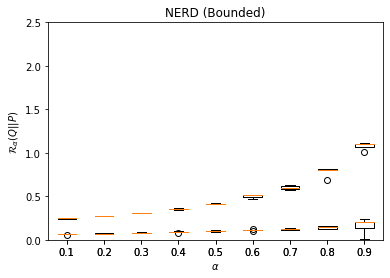

In [10]:


fig1, ax1 = plt.subplots()
ax1.set_title('NERD (Bounded)')
ax1.boxplot(np.transpose(D_loss_vals[:,:]) , labels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], whis=2)
#ax1.plot(np.arange(1,len(alpha_range)+1), RD_exact_rho[:],'r', 'LineWidth', 2 );
ax1.boxplot(np.transpose(D_loss_vals_w_005[:,:]) , labels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], whis=2)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\mathcal{R}_{\alpha}(Q||P)$')
plt.ylim(0.0, 2.5)




In [11]:
# plot errorbars
RD_M50_mean = np.mean(D_loss_vals, axis=1)  # means per alpha value
RD_M50_mean_w_005 = np.mean(D_loss_vals_w_005, axis=1)

RD_M50_std = np.std(D_loss_vals, axis=1)  # means per alpha value
RD_M50_std_w_005 = np.std(D_loss_vals_w_005, axis=1)  # means per alpha value

In [38]:
# load ITE toolbox estimates (runs with matlab, saved in .mat files)
fname = 'data/ITE_computations_H3_H4_H5_H6_H7_vs_CBF_perc4_markers_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_alpha_0.1_upto_0.9_H_first_1minalpha'
data_ITE = scipy.io.loadmat(fname +'.mat')

RD_ITE_mean = np.array(data_ITE['RD_ITE_mean'])
RD_ITE_std = np.array(data_ITE['RD_ITE_std'])

fname = 'data/ITE_computations_H3_H4_H5_H6_H7_vs_CBF_perc2_markers_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_alpha_0.1_upto_0.9_H_first_1minalpha'
data_ITE_w_005 = scipy.io.loadmat(fname +'.mat')

RD_ITE_mean_w_005 = np.array(data_ITE_w_005['RD_ITE_mean'])
RD_ITE_std_w_005 = np.array(data_ITE_w_005['RD_ITE_std'])

(-0.5, 0.3)

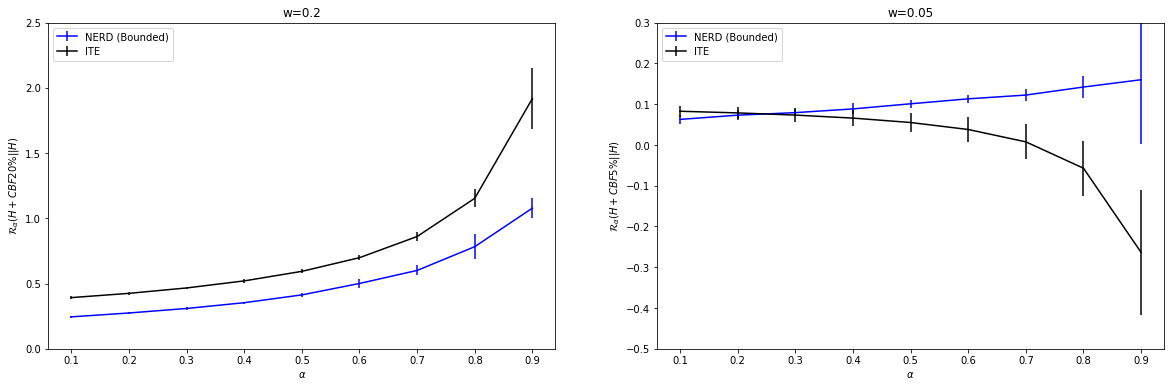

In [39]:
plt.figure(figsize=(20,6))

ax1 = plt.subplot(1,2,1)
ax1.set_title('w=0.2')
ax1.errorbar(alpha_range, RD_M50_mean, 1.96*RD_M50_std, color= 'b', label='NERD (Bounded)')
ax1.errorbar(alpha_range, RD_ITE_mean.ravel(), 1.96*RD_ITE_std.ravel(), color= 'k', label='ITE')

plt.legend(loc=2)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\mathcal{R}_{\alpha}(H+CBF 20\% ||H)$')
plt.ylim(0.0, 2.5)


ax2 = plt.subplot(1,2,2)
ax2.set_title('w=0.05')
ax2.errorbar(alpha_range, RD_M50_mean_w_005, 1.96*RD_M50_std_w_005, color= 'b', label='NERD (Bounded)')
ax2.errorbar(alpha_range, RD_ITE_mean_w_005.ravel(), 1.96*RD_ITE_std_w_005.ravel(), color= 'k', label='ITE')

plt.legend(loc=2)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\mathcal{R}_{\alpha}(H+CBF 5\% ||H)$')
plt.ylim(-0.5, 0.3)


In [40]:
print('program terminated succesfully')

program terminated succesfully
